# RFM Clustering
The intention of this clustering is to segment the customer database according to their purchase behaivor.  The 
k-means algorithm is used as a part of RFM clustering.  This is a popular technique used by companies to predict
the 'health' of their customers.  From these groups, we can see which customers are the most loyal, turning, new and the biggest spenders. The final output is written to a .csv file for further analysis. The code below contains segments of code adapted from an example of RFM clustering presented in "RFM Analysis: An Effective Customer Segmentation technique using Python" cited below.

In [1]:
# Import libraries to environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.ticker as mticker
import squarify
from tabulate import tabulate
from mlxtend.frequent_patterns import apriori, association_rules 

In [2]:
# Create Soap dataframe and set names for all columns
Soap = pd.read_csv("BathSoap.csv")
Names = ['Member id', 'SEC', 'FEH', 'MT', 'SEX', 'AGE', 'EDU', 'HS', 'CHILD', 'CS', 'Affluence Index', 
         'No. of Brands', 'Brand Runs', 'Total Volume', 'No. of  Trans', 'Value', 'Trans / Brand Runs',
         'Vol/Tran', 'Avg. Price', 'Pur Vol No Promo - %','Pur Vol Promo 6 %', 'Pur Vol Other Promo %',
         'Br. Cd. 57, 144', 'Br. Cd. 55', 'Br. Cd. 272', 'Br. Cd. 286', 'Br. Cd. 24', 'Br. Cd. 481', 
         'Br. Cd. 352', 'Br. Cd. 5', 'Others 999', 'Pr Cat 1', 'Pr Cat 2', 'Pr Cat 3', 'Pr Cat 4', 
         'PropCat 5', 'PropCat 6', 'PropCat 7', 'PropCat 8', 'PropCat 9', 'PropCat 10', 'PropCat 11',
         'PropCat 12', 'PropCat 13', 'PropCat 14', 'PropCat 15']
Soap.columns=Names

In [3]:
# RFM Recency = 'Brand Runs', Frequency = 'No. of Trans', Monetary Value = 'Vol/Tran'
# Remove top 1%
Brandr99 = Soap[Soap['Brand Runs']<Soap['Brand Runs'].quantile(0.99)]
Trans99 = Soap[Soap['No. of  Trans']<Soap['No. of  Trans'].quantile(0.99)]
Tvol99 = Soap[Soap['Total Volume']<Soap['Total Volume'].quantile(0.99)]

In [4]:
# Create table of variables for RFM analysis
rfm_table = pd.merge(pd.merge(Brandr99[['Member id','Brand Runs',
            'No. of  Trans','Total Volume']], Trans99[['Member id']],
            on='Member id'),Tvol99[['Member id']],on='Member id')

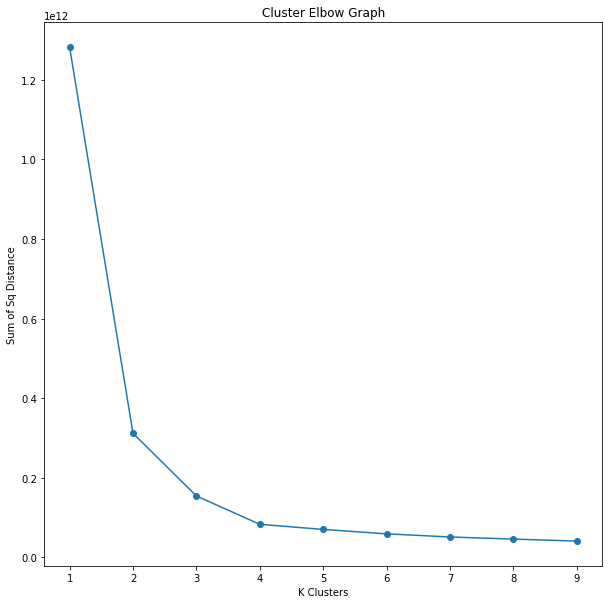

In [5]:
# Create an elbow graph of current dataframe to see optimal number of clusters. In this case 3 appears to be 
# a valid option.
ceg= [] 
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Soap)
    ceg.append(km.inertia_)

plt.figure(figsize=(10, 10))
plt.plot(list_k, ceg, '-o')
plt.xlabel('K Clusters')
plt.ylabel('Sum of Sq Distance')
plt.title("Cluster Elbow Graph");

In [6]:
# Define function for ordering clsuters in next phase
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending= ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [7]:
# Set clusters to 3, create table of predictions for Brand Runs, No. of Transactions, and Volume per Transaction.
km = KMeans(n_clusters=3)
km.fit(rfm_table[['Brand Runs']])
rfm_table['BrandRunCluster']=km.predict(rfm_table[['Brand Runs']])
rfm_table = order_cluster('BrandRunCluster', 'Brand Runs', rfm_table, False)

km = KMeans(n_clusters=3)
km.fit(rfm_table[['No. of  Trans']])
rfm_table['TransCluster']=km.predict(rfm_table[['No. of  Trans']])
rfm_table = order_cluster('TransCluster', 'No. of  Trans', rfm_table, False)

# Set clusters to 3, create table of predictions for Vol/Trans value.
km = KMeans(n_clusters=3)
km.fit(rfm_table[['Total Volume']])
rfm_table['VolCluster']=km.predict(rfm_table[['Total Volume']])
rfm_table = order_cluster('VolCluster', 'Total Volume', rfm_table, False)

In [8]:
# Function to place variables as assigned
def set_value(row_number, assigned_value):
    return assigned_value[row_number]

In [9]:
#Bucket each customer based on min, max, mean results of  'Brand Run', 'No of Trans', and 'Vol/Tran'.
b=rfm_table.groupby('BrandRunCluster')['Brand Runs'].agg(['min','max','mean']).reset_index()
r1='<='+str(b.iloc[2,2])
r2=str(b.iloc[1,1])+' to '+str(b.iloc[1,2])
r3 ='>='+str(b.iloc[0,1])
R ={0 : r3, 1 : r2, 2 : r1}
rfm_table['BrandRunClusterTag'] = rfm_table['BrandRunCluster'].apply(set_value, args=(R, ))

t=rfm_table.groupby('TransCluster')['No. of  Trans'].agg(['min','max','mean']).reset_index()
f1='<='+str(t.iloc[2,2])
f2=str(t.iloc[1,1])+' to '+str(t.iloc[1,2])
f3 ='>='+str(t.iloc[0,1])
F ={0 : f3, 1 : f2, 2 : f1}
rfm_table['TransClusterTag'] = rfm_table['TransCluster'].apply(set_value, args=(F, ))

br=rfm_table.groupby('VolCluster')['Total Volume'].agg(['min','max','mean']).reset_index()
br1='<='+str(br.iloc[2,2])
br2=str(br.iloc[1,1])+' to '+str(br.iloc[1,2])
br3 ='>='+str(br.iloc[0,1])
B ={0 : br3, 1 : br2, 2 : br1}
rfm_table['VolClusterTag'] = rfm_table['VolCluster'].apply(set_value, args=(B, ))

In [10]:
#Assign category to each output. Each cluster will be marked as 0,1,2 depending on min, max, mean.
rfm_table['BrandRunClusterTag'] = rfm_table['BrandRunClusterTag'].astype(pd.api.types.CategoricalDtype(categories=[r1,r2,r3]))
rfm_table['TransClusterTag'] = rfm_table['TransClusterTag'].astype(pd.api.types.CategoricalDtype(categories=[f1,f2,f3]))
rfm_table['VolClusterTag'] = rfm_table['VolClusterTag'].astype(pd.api.types.CategoricalDtype(categories=[br1,br2,br3]))

# Work Cited (RFM Algorithm)

The code used in this output was a demonstration adapted to the Soap dataset. 

1. Karaman, B. (2019, September 15). Customer Segmentation. Retrieved December 16, 2020, from https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444

2.  Singh, A. (2020, May 28). RFM Analysis: An Effective Customer Segmentation technique using Python. Retrieved December 16, 2020, from https://medium.com/capillary-data-science/rfm-analysis-an-effective-customer-segmentation-technique-using-python-58804480d232


In [11]:
# Create new column in data frame and concatenate 'BrandRunCluster' + 'TransCluster' + 'VolCluster' into 
# one 'RFM Score' column
rfm_table['RFM Score'] = [''.join(str(x) for x in y) for y in map(tuple, 
      rfm_table[['BrandRunCluster', 'TransCluster', 'VolCluster']].values)]
rfm_table.head()

,Member id,Brand Runs,No. of Trans,Total Volume,BrandRunCluster,TransCluster,VolCluster,BrandRunClusterTag,TransClusterTag,VolClusterTag,RFM Score
0,1100620,17,32,38925,1,1,0,13 to 24,21 to 41,>=18850,110
1,1070270,15,41,35250,1,1,0,13 to 24,21 to 41,>=18850,110
2,1077390,15,26,30375,1,1,0,13 to 24,21 to 41,>=18850,110
3,1037420,18,41,30350,1,1,0,13 to 24,21 to 41,>=18850,110
4,1111180,21,41,30325,1,1,0,13 to 24,21 to 41,>=18850,110


In [12]:
# Drop columns from data frame that we do not want to measure with summary statistics
Soap = Soap.drop(columns=['Br. Cd. 57, 144', 'Br. Cd. 55', 'Br. Cd. 272', 'Br. Cd. 286', 'Br. Cd. 24', 'Br. Cd. 481', 
         'Br. Cd. 352', 'Br. Cd. 5', 'Others 999', 'Pr Cat 1', 'Pr Cat 2', 'Pr Cat 3', 'Pr Cat 4', 
         'PropCat 5', 'PropCat 6', 'PropCat 7', 'PropCat 8', 'PropCat 9', 'PropCat 10', 'PropCat 11',
         'PropCat 12', 'PropCat 13', 'PropCat 14', 'PropCat 15','Vol/Tran', 'Avg. Price', 'Value', 'Trans / Brand Runs'])

In [13]:
# Merge column 'RFM Score' from rfm_table dataframe to Soap dataframe. 
Soap1 = pd.concat([Soap, rfm_table['RFM Score']], axis=1).reindex(Soap.index)
Soap1.head(n=500)

,Member id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,Affluence Index,No. of Brands,Brand Runs,Total Volume,No. of Trans,Pur Vol No Promo - %,Pur Vol Promo 6 %,Pur Vol Other Promo %,RFM Score
0,1080950,3,3,17,2,4,0,8,2,1,9,4,22,50895,42,0.92,0.05,0.04,110
1,1163760,1,1,4,2,4,4,9,1,1,36,9,57,50000,95,0.95,0.05,0.00,110
2,1104490,2,1,5,2,4,4,15,2,1,10,3,8,48500,28,0.95,0.05,0.00,110
3,1110550,2,3,10,2,4,4,4,4,1,10,7,21,46350,56,0.98,0.01,0.02,110
4,1060920,3,3,17,2,4,5,5,4,1,13,3,14,40475,27,0.99,0.01,0.00,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1121440,1,1,4,2,3,7,5,2,1,26,2,18,5650,21,1.00,0.00,0.00,222
496,1166340,2,1,4,2,4,5,5,4,1,48,3,17,5635,22,0.91,0.00,0.09,222
497,1044140,4,1,4,2,3,4,5,4,1,7,3,12,5600,17,0.73,0.04,0.23,222
498,1125480,3,1,4,1,4,5,2,4,1,8,3,11,5600,21,0.89,0.05,0.05,222


In [14]:
# View how many customers belong to which RFM score groups.  Here we can make an informed decision based on the RFM figure.
# R = Brand Runs, F = No. of Transactions , M = Total Volume. Yeah 
Soap1['RFM Score'].value_counts()

222    104
111     77
112     77
211     60
212     39
001     33
101     27
110     25
122     21
210     20
100     17
000     17
011     16
221     11
002     10
102      8
012      8
201      6
010      3
120      2
200      2
220      1
202      1
121      1
Name: RFM Score, dtype: int64

In [53]:
# Further investigation of clusters of interest
twoonetwo = Soap1['RFM Score'] == '212'
Twoonetwo = Soap1[twoonetwo]
Twoonetwo.head(n=10)

,Member id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,Affluence Index,No. of Brands,Brand Runs,Total Volume,No. of Trans,Pur Vol No Promo - %,Pur Vol Promo 6 %,Pur Vol Other Promo %,RFM Score
482,1085530,3,3,10,2,4,7,3,4,1,13,6,12,6050,21,1.00,0.00,0.00,222
483,1147940,2,3,10,2,2,5,5,1,1,11,4,18,6050,26,0.96,0.04,0.00,222
484,1148380,2,3,10,2,2,9,5,1,1,16,5,16,5950,18,1.00,0.00,0.00,222
485,1162360,1,1,10,2,4,5,4,4,1,26,5,23,5950,31,0.66,0.24,0.10,222
486,1162960,2,1,4,2,4,5,6,3,1,23,4,24,5950,29,0.77,0.23,0.00,222
487,1085590,4,3,10,2,4,4,8,4,0,13,3,8,5900,8,1.00,0.00,0.00,222
488,1145960,1,1,5,2,2,7,3,1,1,26,5,21,5900,30,0.84,0.14,0.02,222
489,1155250,2,1,10,2,4,5,4,4,1,30,3,19,5825,25,0.90,0.00,0.10,222
490,1165090,1,3,10,2,4,5,3,4,1,22,4,15,5800,19,1.00,0.00,0.00,222
491,1081640,2,1,4,2,4,5,6,2,1,36,4,16,5775,24,0.93,0.07,0.00,222


In [54]:
# We can break this down even further by demographic such as child count.
Twoonetwo['CHILD'].value_counts()

5    42
4    29
2    16
1    10
3     7
Name: CHILD, dtype: int64

In [55]:
# Also, summmary statistics will show the average demographic of the '212' RFM Score group. This customer on average
# is worth $7560 to the company. This customer has frequent brand runs and a high purchase amount based on the scoring.
Twoonetwo.describe()

,Member id,SEC,FEH,MT,SEX,AGE,EDU,HS,CHILD,CS,Affluence Index,No. of Brands,Brand Runs,Total Volume,No. of Trans,Pur Vol No Promo - %,Pur Vol Promo 6 %,Pur Vol Other Promo %
count,1.040000e+02,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,1.120818e+06,2.163462,1.182692,5.067308,1.173077,2.990385,3.067308,2.250000,3.740385,0.605769,12.365385,2.932692,10.163462,3767.307692,15.230769,0.902500,0.055288,0.042019
std,4.435206e+04,1.107000,1.244517,4.754690,0.979819,0.908377,2.843027,2.162119,1.379427,0.581566,12.965269,1.240611,6.668446,1684.706468,9.453238,0.142296,0.107775,0.090182
min,1.014030e+06,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,750.000000,1.000000,0.330000,0.000000,0.000000
25%,1.085620e+06,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.750000,0.000000,0.000000,2.000000,4.000000,2293.750000,7.000000,0.867500,0.000000,0.000000
50%,1.143230e+06,2.000000,1.000000,4.000000,2.000000,3.000000,4.000000,2.000000,4.000000,1.000000,11.000000,3.000000,9.000000,4125.000000,14.000000,0.960000,0.000000,0.000000
75%,1.156928e+06,3.000000,3.000000,10.000000,2.000000,4.000000,5.000000,4.000000,5.000000,1.000000,23.000000,4.000000,15.000000,5306.250000,22.250000,1.000000,0.070000,0.042500
max,1.167350e+06,4.000000,3.000000,15.000000,2.000000,4.000000,9.000000,8.000000,5.000000,2.000000,49.000000,6.000000,27.000000,6050.000000,46.000000,1.000000,0.640000,0.500000


# Apriori Algorithm to group frequently purchased items together

In [17]:
#Create new dataframe to start Apriori classification.
ACsoap = pd.read_csv('BathSoap.csv')
Names = ['Member id', 'SEC', 'FEH', 'MT', 'SEX', 'AGE', 'EDU', 'HS', 'CHILD', 'CS', 'Affluence Index', 
         'No. of Brands', 'Brand Runs', 'Total Volume', 'No. of  Trans', 'Value', 'Trans / Brand Runs',
         'Vol/Tran', 'Avg. Price', 'Pur Vol No Promo - %','Pur Vol Promo 6 %', 'Pur Vol Other Promo %',
         'Br. Cd. 57, 144', 'Br. Cd. 55', 'Br. Cd. 272', 'Br. Cd. 286', 'Br. Cd. 24', 'Br. Cd. 481', 
         'Br. Cd. 352', 'Br. Cd. 5', 'Others 999', 'Pr Cat 1', 'Pr Cat 2', 'Pr Cat 3', 'Pr Cat 4', 
         'PropCat 5', 'PropCat 6', 'PropCat 7', 'PropCat 8', 'PropCat 9', 'PropCat 10', 'PropCat 11',
         'PropCat 12', 'PropCat 13', 'PropCat 14', 'PropCat 15']
ACsoap.columns=Names

In [69]:
# Define function that will set values smaller than .01 to 0 and greater than .01 to 1
# This is a data preprocessing step for apriori to decide if an item has been purchased or not.
def encode_units(x):
    if x < 0.01:
        return 0
    if x >= .01:
        return 1

In [70]:
# Preprocess variables to become float types.
Soap['Member id'] = pd.to_numeric(Soap['Member id'], downcast='float')
Soap['SEC'] = pd.to_numeric(Soap['SEC'], downcast='float')
Soap['FEH'] = pd.to_numeric(Soap['FEH'], downcast='float')
Soap['MT'] = pd.to_numeric(Soap['MT'], downcast='float')
Soap['SEX'] = pd.to_numeric(Soap['SEX'], downcast='float')
Soap['AGE'] = pd.to_numeric(Soap['AGE'], downcast='float')
Soap['EDU'] = pd.to_numeric(Soap['EDU'], downcast='float')
Soap['HS'] = pd.to_numeric(Soap['HS'], downcast='float')
Soap['CHILD'] = pd.to_numeric(Soap['CHILD'], downcast='float')
Soap['CS'] = pd.to_numeric(Soap['CS'], downcast='float')
Soap['Affluence Index'] = pd.to_numeric(Soap['Affluence Index'], downcast='float')
Soap['No. of Brands'] = pd.to_numeric(Soap['No. of Brands'], downcast='float')
Soap['Brand Runs'] = pd.to_numeric(Soap['Brand Runs'], downcast='float')
Soap['Total Volume'] = pd.to_numeric(Soap['Total Volume'], downcast='float')
Soap['No. of  Trans'] = pd.to_numeric(Soap['No. of  Trans'], downcast='float')

In [60]:
# Create basket of items that we wish to analyze 
basket = ACsoap.groupby(['Member id','Br. Cd. 57, 144', 'Br. Cd. 55', 'Br. Cd. 272', 'Br. Cd. 286', 'Br. Cd. 24', 'Br. Cd. 481', 
         'Br. Cd. 352', 'Br. Cd. 5', 'Others 999'])['Total Volume'].sum().unstack().reset_index().fillna(0).set_index('Member id')

In [71]:
# Hot encode the variables using the defined fuction above.
basket_sets = basket.applymap(encode_units)

In [86]:
# Set paramaters for frequent items. In this case I tried many values for min_suport and was only able to retrieve enough
# items when the min support was set to .15 or less
frequent_itemsets = apriori(basket_sets, min_support=0.15, use_colnames=True)

In [92]:
# Introduce and evaluate metrics for basket
rules = association_rules(frequent_itemsets, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules.head()) 

      antecedents        consequents  antecedent support  consequent support  \
11    (Br. Cd. 5)  (Br. Cd. 57, 144)            0.275000            0.681667   
8   (Br. Cd. 352)  (Br. Cd. 57, 144)            0.243333            0.681667   
6   (Br. Cd. 481)  (Br. Cd. 57, 144)            0.253333            0.681667   
4    (Br. Cd. 24)  (Br. Cd. 57, 144)            0.231667            0.681667   
2   (Br. Cd. 286)  (Br. Cd. 57, 144)            0.228333            0.681667   

     support  confidence      lift  leverage  conviction  
11  0.220000    0.800000  1.173594  0.032542    1.591667  
8   0.191667    0.787671  1.155508  0.025794    1.499247  
6   0.195000    0.769737  1.129198  0.022311    1.382476  
4   0.171667    0.741007  1.087052  0.013747    1.229120  
2   0.168333    0.737226  1.081506  0.012686    1.211435  


In [93]:
#Create a .csv file of the frequent item results.
with open('Apriori.csv', 'w') as outputfile:
    outputfile.write(tabulate(rules))

# Work Cited (Apriori Algorithm)
Some lines of code were adapted to data. Below is the source of this information.

1. AlindGuptaCheck out this Author's contributed articles., AlindGupta, &amp; Check out this Author's contributed articles. (2019, June 12). Implementing Apriori algorithm in Python. Retrieved December 17, 2020, from https://www.geeksforgeeks.org/implementing-apriori-algorithm-in-python/